# Model 3: Time-Series Anomaly Detector

**Purpose:** Detect unusual CCU spikes that likely came from campaigns

**How it works:**
1. Learn normal CCU patterns for each map
2. Flag when actual CCU is much higher than expected
3. Calculate "anomaly score" for spike detection

**Use cases:**
- Automatically detect campaign-driven spikes
- Alert when organic growth is unusually high
- Measure campaign impact (spike above baseline)

**Without campaign data:** We can detect anomalies but can't attribute them  
**With campaign data:** Can link spikes to specific campaigns

## 1. Import Libraries

In [2]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

sns.set_style('whitegrid')
print("✅ Libraries imported")

✅ Libraries imported


## 2. Load Map Data

In [3]:
DATA_DIR = Path('../data/raw')
map_files = list(DATA_DIR.glob('map_*.json'))
print(f"📊 Found {len(map_files)} map files")

📊 Found 962 map files


## 3. Extract Time-Series Data

In [4]:
def extract_timeseries_data(map_file):
    """Extract time-series CCU data for anomaly detection"""
    try:
        with open(map_file, 'r') as f:
            data = json.load(f)
        
        map_data = data['map_data']
        stats_7d = data.get('stats_7d', {})
        
        if not stats_7d.get('success'):
            return None
        
        ccu_values = stats_7d.get('data', {}).get('stats', [])
        if len(ccu_values) < 50:  # Need sufficient data
            return None
        
        return {
            'map_code': map_data.get('id'),
            'name': map_data.get('name', 'Unknown'),
            'ccu_timeseries': ccu_values,
            'current_ccu': map_data.get('lastSyncCcu', 0)
        }
    except:
        return None

print("✅ Extraction function defined")

✅ Extraction function defined


In [5]:
# Process all maps
print("🔄 Extracting time-series data...")
timeseries_list = []

for i, map_file in enumerate(map_files):
    if i % 100 == 0:
        print(f"   {i}/{len(map_files)}...", end='\r')
    
    ts_data = extract_timeseries_data(map_file)
    if ts_data:
        timeseries_list.append(ts_data)

print(f"\n✅ Processed {len(timeseries_list)} maps with time-series data")

🔄 Extracting time-series data...
   900/962...
✅ Processed 961 maps with time-series data


## 4. Statistical Anomaly Detection

In [6]:
def detect_statistical_anomalies(ccu_series, threshold=2.5):
    """Detect anomalies using Z-score method"""
    arr = np.array(ccu_series)
    mean = np.mean(arr)
    std = np.std(arr)
    
    if std == 0:
        return [], [], 0
    
    # Calculate Z-scores
    z_scores = np.abs((arr - mean) / std)
    
    # Find anomalies (Z-score > threshold)
    anomaly_indices = np.where(z_scores > threshold)[0]
    anomaly_scores = z_scores[anomaly_indices]
    
    # Count significant spikes
    num_spikes = len(anomaly_indices)
    
    return anomaly_indices.tolist(), anomaly_scores.tolist(), num_spikes

print("✅ Statistical anomaly detection defined")

✅ Statistical anomaly detection defined


In [7]:
# Detect anomalies in all maps
print("🔍 Detecting anomalies...")

anomaly_results = []
for ts_data in timeseries_list:
    indices, scores, num_spikes = detect_statistical_anomalies(ts_data['ccu_timeseries'])
    
    if num_spikes > 0:
        anomaly_results.append({
            'map_code': ts_data['map_code'],
            'name': ts_data['name'],
            'num_spikes': num_spikes,
            'max_anomaly_score': max(scores) if scores else 0,
            'spike_indices': indices,
            'spike_scores': scores,
            'ccu_series': ts_data['ccu_timeseries']
        })

print(f"✅ Found {len(anomaly_results)} maps with anomalies")
print(f"   Total spikes detected: {sum(r['num_spikes'] for r in anomaly_results)}")

🔍 Detecting anomalies...
✅ Found 788 maps with anomalies
   Total spikes detected: 4837


## 5. Machine Learning Anomaly Detection

In [8]:
# Prepare features for ML-based detection
print("🤖 Training ML anomaly detector...")

# Create feature matrix from time-series
feature_matrix = []
map_codes = []

for ts_data in timeseries_list:
    ccu_arr = np.array(ts_data['ccu_timeseries'])
    
    # Statistical features
    features = [
        np.mean(ccu_arr),
        np.std(ccu_arr),
        np.max(ccu_arr),
        np.min(ccu_arr),
        np.max(ccu_arr) - np.mean(ccu_arr),  # Peak deviation
        np.std(ccu_arr) / max(np.mean(ccu_arr), 1),  # Coefficient of variation
        np.max(np.diff(ccu_arr)),  # Max jump
        np.percentile(ccu_arr, 95),  # 95th percentile
    ]
    
    feature_matrix.append(features)
    map_codes.append(ts_data['map_code'])

X = np.array(feature_matrix)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
iso_forest = IsolationForest(
    contamination=0.1,  # Expect 10% anomalies
    random_state=42,
    n_estimators=100
)
iso_forest.fit(X_scaled)

# Get anomaly scores (lower = more anomalous)
anomaly_scores = iso_forest.score_samples(X_scaled)
anomaly_labels = iso_forest.predict(X_scaled)  # -1 = anomaly, 1 = normal

print(f"✅ Trained Isolation Forest")
print(f"   Anomalies detected: {(anomaly_labels == -1).sum()}")

🤖 Training ML anomaly detector...
✅ Trained Isolation Forest
   Anomalies detected: 96


## 6. Combine Results & Analysis

In [9]:
# Create results DataFrame
results_df = pd.DataFrame({
    'map_code': map_codes,
    'anomaly_score': anomaly_scores,
    'is_anomaly': anomaly_labels == -1
})

# Add map names
name_map = {ts['map_code']: ts['name'] for ts in timeseries_list}
results_df['name'] = results_df['map_code'].map(name_map)

# Sort by anomaly score (most anomalous first)
results_df = results_df.sort_values('anomaly_score')

print("📊 Top 10 Most Anomalous Maps:")
print("="*70)
print(results_df.head(10)[['map_code', 'name', 'anomaly_score', 'is_anomaly']].to_string(index=False))

📊 Top 10 Most Anomalous Maps:
      map_code                                     name  anomaly_score  is_anomaly
4554-4413-1515                      FRUITS VS BRAINROTS      -0.852998        True
2898-7886-8847                     CRAZY RED VS BLUE 🔴🔵      -0.811342        True
0497-4522-9912                      GARDEN VS BRAINROTS      -0.809150        True
0148-0322-5437                      Piece Control 2v2 🎯      -0.805213        True
8765-4125-9209 1v1v1 Reload 1v1 Realistics Free for All      -0.799355        True
7835-3901-1999                  1v1 Build Fight [Rezon]      -0.775940        True
7048-8422-2298                                 Bed Wars      -0.770113        True
1732-8037-8844          SQUID GAME PILLARS - SQUIDLLARS      -0.758121        True
4274-1432-8830                   🧠 Brainrot Boxfights 📦      -0.755966        True
6980-7830-5270                            Barber Tycoon      -0.754539        True


## 7. Visualize Example Anomalies

/var/folders/kw/2hsq_mwn1rs46n451sj950200000gn/T/ipykernel_77365/751963741.py:37: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  plt.tight_layout()
/var/folders/kw/2hsq_mwn1rs46n451sj950200000gn/T/ipykernel_77365/751963741.py:37: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from current font.
  plt.tight_layout()
/var/folders/kw/2hsq_mwn1rs46n451sj950200000gn/T/ipykernel_77365/751963741.py:37: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/Users/nicholasrivera/.pyenv/versions/3.11.9/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nicholasrivera/.pyenv/versions/3.11.9/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nicholasrive

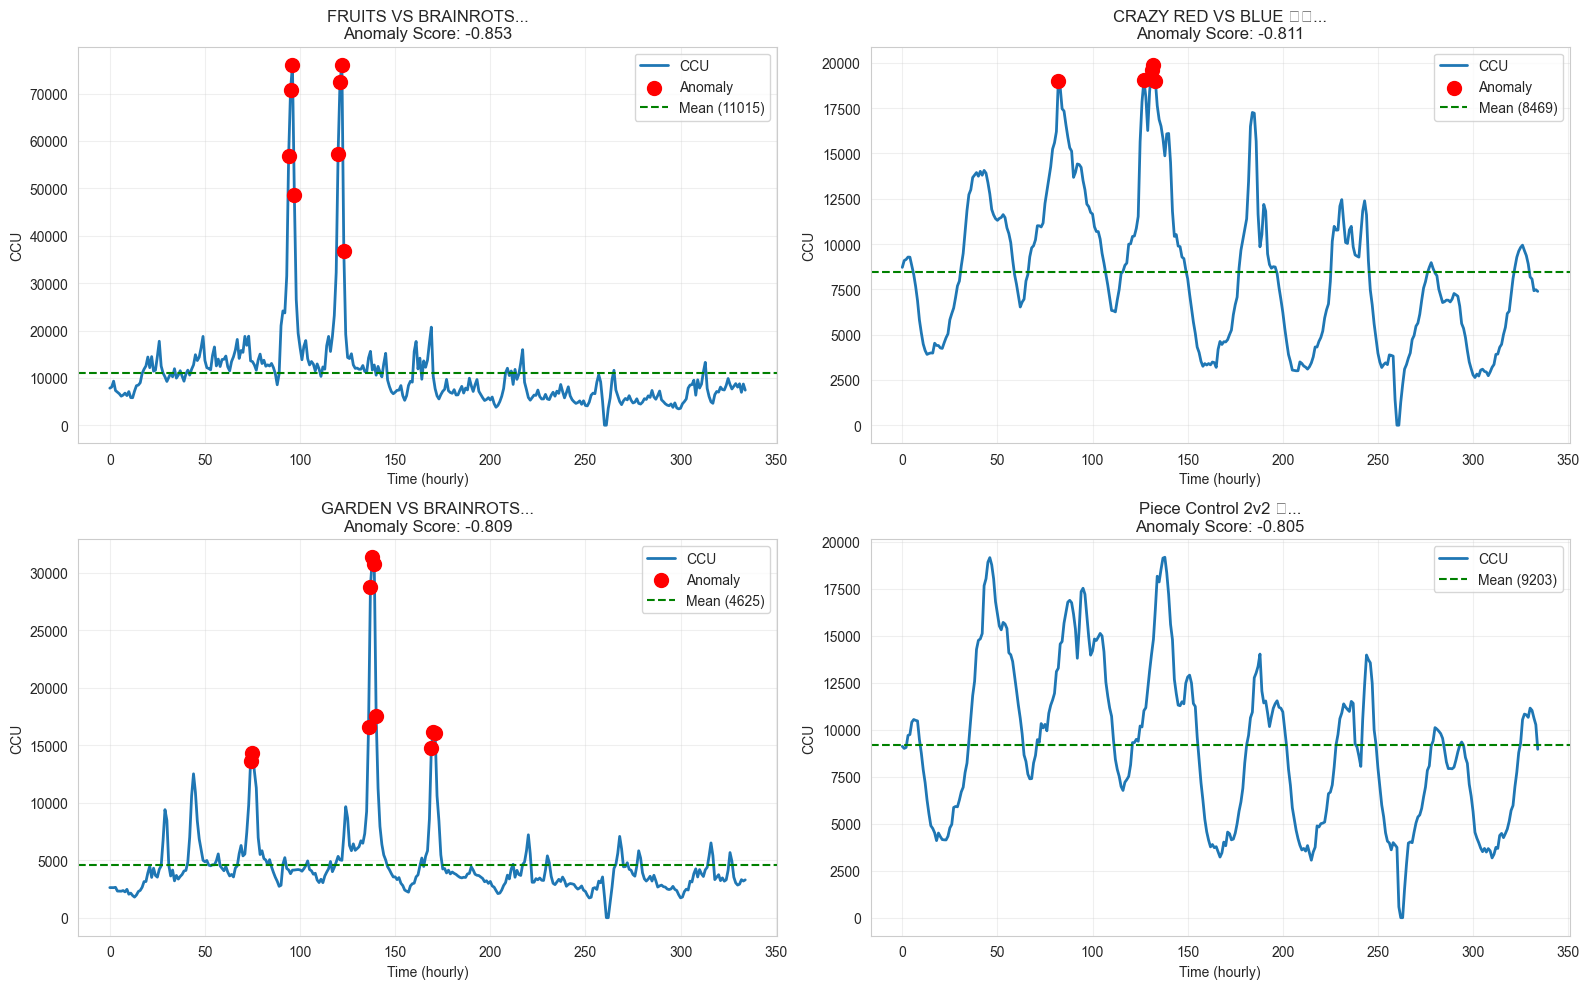

In [10]:
# Plot examples
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Get top 4 anomalous maps
top_anomalies = results_df.head(4)

for idx, (_, row) in enumerate(top_anomalies.iterrows()):
    map_code = row['map_code']
    ts_data = next((ts for ts in timeseries_list if ts['map_code'] == map_code), None)
    
    if ts_data:
        ccu_series = ts_data['ccu_timeseries']
        
        # Statistical anomaly detection for this map
        indices, scores, _ = detect_statistical_anomalies(ccu_series)
        
        # Plot
        ax = axes[idx]
        ax.plot(ccu_series, label='CCU', linewidth=2)
        
        # Mark anomalies
        if indices:
            ax.scatter(indices, [ccu_series[i] for i in indices], 
                      color='red', s=100, zorder=5, label='Anomaly')
        
        # Mean line
        mean_ccu = np.mean(ccu_series)
        ax.axhline(mean_ccu, color='green', linestyle='--', label=f'Mean ({mean_ccu:.0f})')
        
        ax.set_xlabel('Time (hourly)')
        ax.set_ylabel('CCU')
        ax.set_title(f"{ts_data['name'][:30]}...\nAnomaly Score: {row['anomaly_score']:.3f}")
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Save Anomaly Detector

In [11]:
models_dir = Path('../data/models')
models_dir.mkdir(exist_ok=True)

# Save model
joblib.dump(iso_forest, models_dir / 'anomaly_detector.pkl')
print(f"✅ Model saved: {models_dir / 'anomaly_detector.pkl'}")

# Save scaler
joblib.dump(scaler, models_dir / 'anomaly_scaler.pkl')
print(f"✅ Scaler saved: {models_dir / 'anomaly_scaler.pkl'}")

# Save metadata
metadata = {
    'model_type': 'anomaly_detection',
    'algorithm': 'IsolationForest',
    'contamination': 0.1,
    'training_samples': len(X),
    'anomalies_detected': int((anomaly_labels == -1).sum()),
    'date_trained': datetime.now().isoformat()
}
with open(models_dir / 'anomaly_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved")

✅ Model saved: ../data/models/anomaly_detector.pkl
✅ Scaler saved: ../data/models/anomaly_scaler.pkl
✅ Metadata saved


## 9. Summary

In [12]:
print("\n" + "="*70)
print("🎉 ANOMALY DETECTOR TRAINING COMPLETE!")
print("="*70)
print(f"\n✅ Training samples: {len(X)}")
print(f"✅ Anomalies detected: {(anomaly_labels == -1).sum()}")
print(f"✅ Anomaly rate: {(anomaly_labels == -1).sum() / len(anomaly_labels) * 100:.1f}%")

print("\n💡 HOW TO USE:")
print("   Input: Time-series CCU data for a map")
print("   Output: Anomaly score + spike detection")
print("   Use case: Detect campaign-driven spikes automatically!")

print("\n🎯 NEXT STEP:")
print("   When client provides campaign data, we can:")
print("   - Attribute spikes to specific campaigns")
print("   - Measure campaign lift")
print("   - Calculate ROI")
print("="*70)


🎉 ANOMALY DETECTOR TRAINING COMPLETE!

✅ Training samples: 961
✅ Anomalies detected: 96
✅ Anomaly rate: 10.0%

💡 HOW TO USE:
   Input: Time-series CCU data for a map
   Output: Anomaly score + spike detection
   Use case: Detect campaign-driven spikes automatically!

🎯 NEXT STEP:
   When client provides campaign data, we can:
   - Attribute spikes to specific campaigns
   - Measure campaign lift
   - Calculate ROI
